This script is a comprehensive solution for employee performance monitoring using YOLOv8 for pose detection and machine learning classifiers for behavior classification.

In [1]:
#Importing necessary libraries
%%capture
!pip install roboflow
!pip install ultralytics

In [ ]:
#Call dataset from roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="GojoMvCjgAWvG6j6hFe8")
project = rf.workspace("project-x2uaa").project("employee-performance-monitoring")
version = project.version(4)
dataset = version.download("yolov8")

In [2]:
import cv2

def read_boxes_from_file(txt_file_path):
    """
    Reads bounding box information from a text file.
    Args:
        txt_file_path (str): Path to the text file containing bounding box information.
    Returns:
        list: A list of dictionaries containing class ID and normalized bounding box coordinates.
    """
    boxes = []
    with open(txt_file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            boxes.append({
                'class_id': class_id,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })
    return boxes

def crop_boxes_from_image(image_path, boxes):
    """
    Crops bounding boxes from an image and saves them as separate files.
    Args:
        image_path (str): Path to the image file.
        boxes (list): List of bounding box information.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    height, width, _ = image.shape
    cropped_images=[]
    classes=[]
    for idx, box in enumerate(boxes):
        x_center = int(box['x_center'] * width)
        y_center = int(box['y_center'] * height)
        box_width = int(box['width'] * width)
        box_height = int(box['height'] * height)
        classe = box['class_id']
        x_min = max(0, x_center - box_width // 2)
        y_min = max(0, y_center - box_height // 2)
        x_max = min(width, x_center + box_width // 2)
        y_max = min(height, y_center + box_height // 2)
        cropped_box = image[y_min:y_max, x_min:x_max]
        cropped_images.append(cropped_box)
        classes.append(classe)

    return cropped_images,classes


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import csv

# Define the CSV file name
output_csv = "keypoints_data_train.csv"
headers = [
    "image_name", "classid", "Nose_x", "Nose_y",
    "Eye_x", "Eye_y", "Ear_x", "Ear_y",
    "Shoulder_x", "Shoulder_y", "Elbow_x", "Elbow_y",
    "Wrist_x", "Wrist_y", "Hip_x", "Hip_y", "Knee_x", "Knee_y",
    "Ankle_x", "Ankle_y"
]

# Create the new CSV file and write the header
with open(output_csv, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(headers)

print(f"New CSV file '{output_csv}' created with headers: {headers}")



New CSV file 'keypoints_data_train.csv' created with headers: ['image_name', 'classid', 'Nose_x', 'Nose_y', 'Eye_x', 'Eye_y', 'Ear_x', 'Ear_y', 'Shoulder_x', 'Shoulder_y', 'Elbow_x', 'Elbow_y', 'Wrist_x', 'Wrist_y', 'Hip_x', 'Hip_y', 'Knee_x', 'Knee_y', 'Ankle_x', 'Ankle_y']


In [5]:
def divide_keypoints_without_confidence(keypoints):
    """
    Divide keypoints into left-side and right-side lists, including Nose in both.
    Confidence values are removed.

    Args:
        keypoints (list): A list of keypoints in the format [x, y, confidence].

    Returns:
        left_side (list): Keypoints for the left side, including the Nose (x, y only).
        right_side (list): Keypoints for the right side, including the Nose (x, y only).
    """
    left_side=[]
    right_side=[]
    left_indices = [0, 1, 3, 5, 7, 9, 11, 13, 15]
    right_indices = [0, 2, 4, 6, 8, 10, 12, 14, 16]
    for i in left_indices:
      left_side.append(keypoints[i][0])
      left_side.append(keypoints[i][1])
    for i in right_indices:
      right_side.append(keypoints[i][0])
      right_side.append(keypoints[i][1])

    return left_side, right_side

In [6]:
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import cv2
import os
images_paths='/content/Employee-Performance-Monitoring-4/train/images/'
images_list=os.listdir(images_paths)
label_paths='/content/Employee-Performance-Monitoring-4/train/labels/'
model = YOLO("yolov8x-pose-p6.pt")
for image_name in images_list:
    label_name=image_name.replace('.jpg','.txt')
    label_path=f'{label_paths}{label_name}'
    image_path=images_paths+image_name
    boxes=read_boxes_from_file(label_path)
    images,classes=crop_boxes_from_image(image_path,boxes)
    for image,clase in zip(images,classes):
      results=model(image, verbose=False)
      keypoints=results[0].keypoints.data.tolist()[0]
      if len(results[0].keypoints.data.tolist()[0])>0:
        left,right=divide_keypoints_without_confidence(keypoints)
        if left.count(0)<right.count(0):
                     sidee=left
        else:
                     sidee=right


        row = [image_name, clase] + sidee
        with open(output_csv, 'a', newline='') as csvfile:
                  csvwriter = csv.writer(csvfile)
                  csvwriter.writerow(row)

        # print(keypoints)
        # break
        # for keypoint in results[0].keypoints.data.tolist()[0]:
        #         x, y, confidence = keypoint
        #         if confidence >= 0.0:
        #           cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)
        # cv2_imshow(image)



100%|██████████| 190M/190M [00:00<00:00, 278MB/s]


In [7]:
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import cv2
import os
images_paths='/content/Employee-Performance-Monitoring-4/valid/images/'
images_list=os.listdir(images_paths)
label_paths='/content/Employee-Performance-Monitoring-4/valid/labels/'
model = YOLO("yolov8x-pose-p6.pt")
for image_name in images_list:
    label_name=image_name.replace('.jpg','.txt')
    label_path=f'{label_paths}{label_name}'
    image_path=images_paths+image_name
    boxes=read_boxes_from_file(label_path)
    images,classes=crop_boxes_from_image(image_path,boxes)
    for image,clase in zip(images,classes):
      results=model(image, verbose=False)
      keypoints=results[0].keypoints.data.tolist()[0]
      if len(results[0].keypoints.data.tolist()[0])>0:
        left,right=divide_keypoints_without_confidence(keypoints)
        if left.count(0)<right.count(0):
                     sidee=left
        else:
                     sidee=right


        row = [image_name, clase] + sidee
        with open(output_csv, 'a', newline='') as csvfile:
                  csvwriter = csv.writer(csvfile)
                  csvwriter.writerow(row)

        # print(keypoints)
        # break
        # for keypoint in results[0].keypoints.data.tolist()[0]:
        #         x, y, confidence = keypoint
        #         if confidence >= 0.0:
        #           cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)
        # cv2_imshow(image)



In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd


csv_path = "/content/keypoints_data_train.csv"
data = pd.read_csv(csv_path)

data = data.drop(columns=["image_name"])

coordinate_columns = [col for col in data.columns if "_x" in col or "_y" in col]


X = data[coordinate_columns]

y = data["classid"]
#y = [1 if val == 1 else 0 for val in y]
#y = [1 if val in (0, 1, 2) else 0 for val in y]

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
scaler_min = scaler.min_
scaler_scale = scaler.scale_

print("Scaler Min:", scaler_min)
print("Scaler Scale:", scaler_scale)
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.2, random_state=42, stratify=y
)

Scaler Min: [          0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0]
Scaler Scale: [   0.003119   0.0043794   0.0023268   0.0044895   0.0021736   0.0033437    0.002425   0.0025285   0.0017707   0.0017331   0.0018528   0.0020407   0.0020699   0.0021423   0.0028902   0.0020171   0.0026108   0.0016609]


In [10]:
X

,Nose_x,Nose_y,Eye_x,Eye_y,Ear_x,Ear_y,Shoulder_x,Shoulder_y,Elbow_x,Elbow_y,Wrist_x,Wrist_y,Hip_x,Hip_y,Knee_x,Knee_y,Ankle_x,Ankle_y
0,59.806911,12.930101,61.802517,11.319556,0.000000,0.000000,66.555908,22.747150,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0.000000,0.000000,47.110573,122.442261,39.204967,124.723793,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,19.851765,27.383400,23.600649,24.225731,30.350588,26.671278,35.327965,49.319965,41.949249,76.989120,39.614792,99.941742,28.292635,102.966957,24.801392,139.294876,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.739397,49.874981,10.631167,95.486580,29.620935,119.204849,24.199900,130.663162,0.000000,0.000000,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,37.023579,27.523338,43.725765,55.346500,53.441139,78.910934,0.000000,0.000000,39.539600,104.673729,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4081,0.000000,0.000000,0.000000,0.000000,86.322113,28.397335,61.961601,64.016029,68.069695,111.794044,0.000000,0.000000,36.788082,137.923553,42.600731,166.865921,0.0,0.0
4082,0.000000,0.000000,0.000000,0.000000,39.116619,46.925621,21.812643,78.712090,35.485497,136.780212,61.394020,136.096466,27.901445,168.479431,0.000000,0.000000,0.0,0.0
4083,41.257889,30.121387,45.538879,26.784870,56.444473,33.736374,67.688461,72.226974,56.536526,127.575127,15.891823,147.710724,62.966225,153.339096,0.000000,0.000000,0.0,0.0
4084,32.534599,32.494541,35.683670,28.128296,41.628445,28.013006,45.575100,53.191856,47.936344,90.258240,31.260250,114.368027,36.836067,117.897202,0.000000,0.000000,0.0,0.0


In [11]:
scaler_scale

array([   0.003119,   0.0043794,   0.0023268,   0.0044895,   0.0021736,   0.0033437,    0.002425,   0.0025285,   0.0017707,   0.0017331,   0.0018528,   0.0020407,   0.0020699,   0.0021423,   0.0028902,   0.0020171,   0.0026108,   0.0016609])

In [12]:

svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.72

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.74      0.98      0.84       533
           2       0.73      0.43      0.54        96
           3       0.46      0.32      0.38        82
           4       0.00      0.00      0.00        46
           5       1.00      0.08      0.14        26

    accuracy                           0.72       818
   macro avg       0.49      0.30      0.32       818
weighted avg       0.65      0.72      0.65       818



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.82

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.17      0.27        35
           1       0.84      0.97      0.90       533
           2       0.93      0.70      0.80        96
           3       0.67      0.59      0.62        82
           4       0.67      0.48      0.56        46
           5       0.74      0.54      0.62        26

    accuracy                           0.82       818
   macro avg       0.75      0.57      0.63       818
weighted avg       0.82      0.82      0.81       818



In [14]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.72

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.74      0.98      0.84       533
           2       0.76      0.35      0.48        96
           3       0.53      0.28      0.37        82
           4       0.20      0.02      0.04        46
           5       0.47      0.31      0.37        26

    accuracy                           0.72       818
   macro avg       0.45      0.32      0.35       818
weighted avg       0.65      0.72      0.66       818



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [15]:
from joblib import dump

# Save different models
dump(svm_model, '/content/drive/MyDrive/Activity_classification/two_classes_ondisk_not_svm_modelv2.joblib')  # SVM
dump(rf_model, '/content/drive/MyDrive/Activity_classification/two_classes_ondisk_not_random_forest_modelv2.joblib')  # Random Forest
dump(lr_model, '/content/drive/MyDrive/Activity_classification/two_classes_ondisk_not_logistic_regression_modelv2.joblib')  # Logistic Regression

print("Models saved successfully.")


Models saved successfully.


In [25]:
from ultralytics import YOLO
model=YOLO('yolov8m.pt')
results = model.train(data="/content/Employee-Performance-Monitoring-4/data.yaml", epochs=100, imgsz=640,project='/content/drive/MyDrive/Activity_classification/train')

train: Scanning /content/Employee-Performance-Monitoring-4/train/labels.cache... 2432 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2432/2432 [00:00<?, ?it/s]
val: Scanning /content/Employee-Performance-Monitoring-4/valid/labels.cache... 149 images, 0 backgrounds, 0 corrupt: 100%|██████████| 149/149 [00:00<?, ?it/s]
      1/100      13.2G      1.731      2.089      1.659         95        640: 100%|██████████| 152/152 [01:21<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]
      2/100      6.74G      1.704      1.515       1.63        127        640: 100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]
      3/100      6.94G      1.687      1.426      1.609         75        640: 100%|██████████| 152/152 [01:18<00:00,  1.93it/s]
                 C

In [27]:
print(results)

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c8ee34d8e80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

Testing

In [21]:
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import cv2
import os
from joblib import load
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import csv
images_paths='/content/Employee-Performance-Monitoring-4/test/images/'
images_list=os.listdir(images_paths)
label_paths='/content/Employee-Performance-Monitoring-4/test/labels/'
svm_model1 = load('/content/two_classes_ondisk_not_svm_modelv3.joblib')
rf_model1 = load('/content/two_classes_ondisk_not_random_forest_modelv3.joblib')
lr_model1 = load('/content/two_classes_ondisk_not_logistic_regression_modelv3.joblib')
model = YOLO("yolov8x-pose-p6.pt")
csv_file_path = '/content/drive/MyDrive/Activity_classification/true_predicted_classes.csv'


with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["True Class", "Predicted Class"])
    for image_name in images_list:
        label_name=image_name.replace('.jpg','.txt')
        label_path=f'{label_paths}{label_name}'
        image_path=images_paths+image_name
        boxes=read_boxes_from_file(label_path)
        images,classes=crop_boxes_from_image(image_path,boxes)
        for image,clase in zip(images,classes):
          results=model(image, verbose=False)
          keypoints=results[0].keypoints.data.tolist()[0]
          if len(results[0].keypoints.data.tolist()[0])>0:
            left,right=divide_keypoints_without_confidence(keypoints)
            if left.count(0)<right.count(0):
                        sidee=left
            else:
                        sidee=right
            features = np.array(sidee)
            features_reshaped = features.reshape(1, -1)
            scaler = MinMaxScaler()
            scaler.min_ = np.array([0.0, 0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])  # Min values used during training
            scaler.scale_ = np.array([0.003119,   0.0043794,   0.0023268,   0.0044895,   0.0021736,   0.0033437,    0.002425,   0.0025285,   0.0017707,   0.0017331,   0.0018528,   0.0020407,   0.0020699,   0.0021423,   0.0028902,   0.0020171,   0.0026108,   0.0016609])
            normalized_features = scaler.transform(features_reshaped)
            svm_predictions = svm_model1.predict_proba(normalized_features)
            rf_predictions = rf_model1.predict_proba(normalized_features)
            lr_predictions = lr_model1.predict_proba(normalized_features)
            max_index_svm, max_value_svm = max(enumerate(svm_predictions[0]), key=lambda x: x[1])
            max_index_lr, max_value_lr = max(enumerate(lr_predictions[0]), key=lambda x: x[1])
            max_index_rf, max_value_rf = max(enumerate(rf_predictions[0]), key=lambda x: x[1])
            classs=[(max_index_svm, max_value_svm),(max_index_lr, max_value_lr),(max_index_rf, max_value_rf )]
            max_tuple = max(classs, key=lambda x: x[1])

            writer.writerow([clase, max_tuple[0]])




        # print(keypoints)
        # break
        # for keypoint in results[0].keypoints.data.tolist()[0]:
        #         x, y, confidence = keypoint
        #         if confidence >= 0.0:
        #           cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)
        # cv2_imshow(image)



In [22]:
import pandas as pd

# Load the uploaded file
file_path = '/content/drive/MyDrive/Activity_classification/true_predicted_classes.csv'
data = pd.read_csv(file_path)

# Display the data to ensure it loaded correctly
data.head()


,True Class,Predicted Class
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [23]:
!pip install ace_tools

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Evaluation Metrics:
      Metric     Value
0   Accuracy  0.854489
1  Precision  0.783914
2     Recall  0.854489
3   F1 Score  0.811439

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.87      1.00      0.93       257
           2       0.80      0.80      0.80         5
           3       0.64      0.39      0.49        23
           4       0.33      0.10      0.15        10
           5       0.71      0.56      0.62         9

    accuracy                           0.85       323
   macro avg       0.56      0.47      0.50       323
weighted avg       0.78      0.85      0.81       323



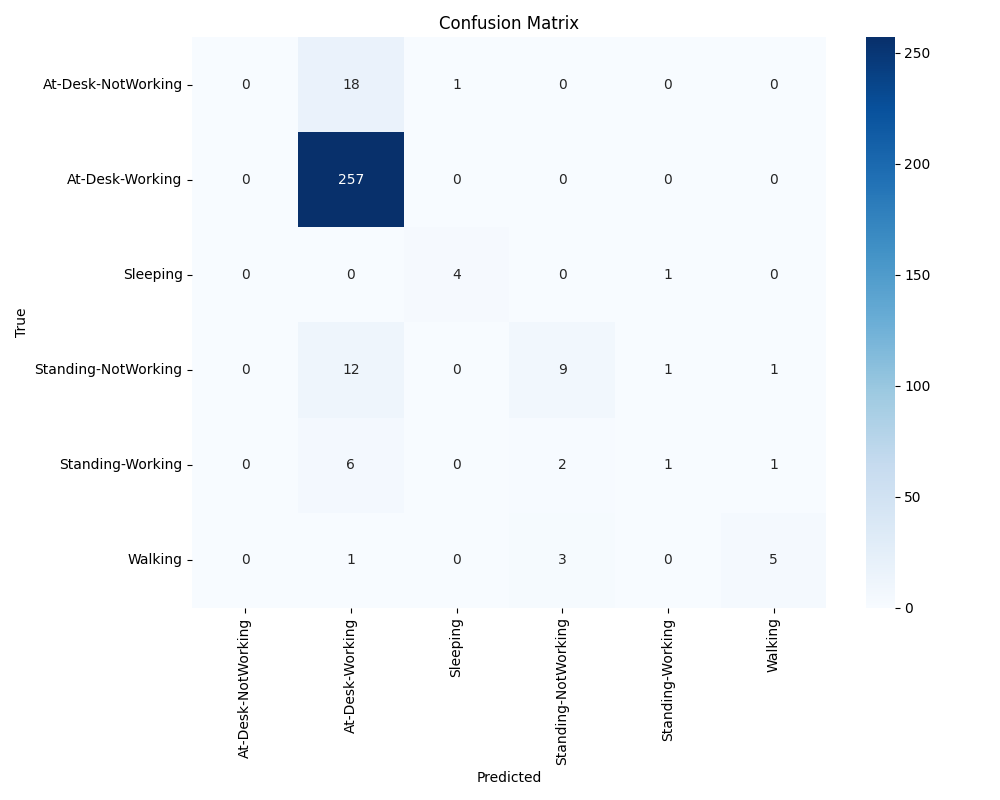

In [24]:
# Update confusion matrix visualization with class names
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
import cv2

# Extract true and predicted classes
true_classes = data['True Class']
predicted_classes = data['Predicted Class']

# Calculate evaluation metrics
accuracy = accuracy_score(true_classes, predicted_classes)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')
class_report = classification_report(true_classes, predicted_classes)



class_names = ['At-Desk-NotWorking', 'At-Desk-Working', 'Sleeping',
               'Standing-NotWorking', 'Standing-Working', 'Walking']

# Save confusion matrix with class names
def save_named_confusion_matrix(conf_matrix, class_names, file_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(file_name)
    plt.close()

# Save the updated confusion matrix
named_confusion_matrix_path = 'named_confusion_matrix.png'
save_named_confusion_matrix(conf_matrix, class_names, named_confusion_matrix_path)
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Value": [accuracy, precision, recall, f1]
})
print("Evaluation Metrics:")
print(metrics_df)

print("\nClassification Report:")
print(class_report)
from google.colab.patches import cv2_imshow
image = cv2.imread('/content/named_confusion_matrix.png')
cv2_imshow(image)